In [1]:
# data processing
import pandas as pd 
import numpy as np 
import statistics

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.neighbors import LocalOutlierFactor
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.regression import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_curve, auc,recall_score,f1_score, precision_score, classification_report, confusion_matrix, auc, mean_squared_error

## Reading data files for each season

In [2]:
all_df = pd.read_csv('../data/annual_data/annual_data_processed.csv')
s2014 = pd.read_csv('../data/annual_data/season_22014_data.csv')
s2015 = pd.read_csv('../data/annual_data/season_22015_data.csv')
s2016 = pd.read_csv('../data/annual_data/season_22016_data.csv')
s2017 = pd.read_csv('../data/annual_data/season_22017_data.csv')
s2018 = pd.read_csv('../data/annual_data/season_22018_data.csv')
s2019 = pd.read_csv('../data/annual_data/season_22019_data.csv')
s2020 = pd.read_csv('../data/annual_data/season_22020_data.csv')

In [3]:
all_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8155 entries, 0 to 8154
Data columns (total 104 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Unnamed: 0           int64  
 1   Unnamed: 0.1         int64  
 2   SEASON_ID_x          int64  
 3   TEAM_ID_x            int64  
 4   TEAM_ABBREVIATION_x  object 
 5   TEAM_NAME_x          object 
 6   GAME_ID              int64  
 7   GAME_DATE_x          object 
 8   MATCHUP_x            object 
 9   WL_x                 int64  
 10  MIN_x                int64  
 11  PTS_x                int64  
 12  FGM_x                int64  
 13  FGA_x                int64  
 14  FG_PCT_x             float64
 15  FG3M_x               int64  
 16  FG3A_x               float64
 17  FG3_PCT_x            float64
 18  FTM_x                int64  
 19  FTA_x                int64  
 20  FT_PCT_x             float64
 21  OREB_x               float64
 22  DREB_x               float64
 23  REB_x                float64
 24  AST

## Filtering out only relevant features

In [4]:
features = ['DIS_PTS', 'DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']

In [5]:
# change the season to check for every season
filtered_df = all_df[features]
filtered_df.tail()

,DIS_PTS,DIS_AST,DIS_OREB,DIS_DREB,DIS_OFF_EFF,DIS_DEF_EFF,DIS_ELO
8150,1.00,4.20,2.17,0.91,-3.47,-1.41,-63.732
8151,15.89,3.76,-0.04,2.75,11.58,-2.87,230.472
8152,-1.10,0.79,-1.00,1.00,-5.91,-1.34,-116.010
8153,9.01,3.22,-0.53,-3.62,10.16,3.34,144.196
8154,2.05,3.08,-0.21,-0.77,-1.11,-1.59,-65.126


## Correlation Check
- Bivariate correlation check 
- Variance Inflation Factor (VIF) for multi-collinearity check
    - VIF starts at 1 and has no upper limit
    - VIF = 1, no correlation between the independent variable and the other variables
    - VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In [6]:
filtered_df.corr(method='pearson')

,DIS_PTS,DIS_AST,DIS_OREB,DIS_DREB,DIS_OFF_EFF,DIS_DEF_EFF,DIS_ELO
DIS_PTS,1.000000,0.602812,0.227115,0.555750,0.899544,0.456334,0.401458
DIS_AST,0.602812,1.000000,-0.058168,0.330704,0.523328,0.178788,0.339617
DIS_OREB,0.227115,-0.058168,1.000000,0.139391,0.193359,0.203987,-0.055994
DIS_DREB,0.555750,0.330704,0.139391,1.000000,0.468945,0.089078,0.310210
DIS_OFF_EFF,0.899544,0.523328,0.193359,0.468945,1.000000,0.485209,0.470872
DIS_DEF_EFF,0.456334,0.178788,0.203987,0.089078,0.485209,1.000000,-0.338744
DIS_ELO,0.401458,0.339617,-0.055994,0.310210,0.470872,-0.338744,1.000000


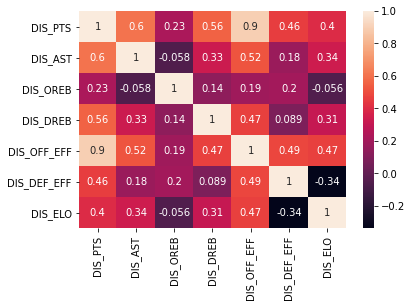

In [7]:
corr = filtered_df.corr(method='pearson')
sns.heatmap(corr, 
            xticklabels = corr.columns.values,
            yticklabels = corr.columns.values,
            annot = True)
plt.show()

- most variables are not strongly correlated 
- highest having a score of 0.90 (DIS_PTS & DIS_OFF_EFF)

In [8]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [9]:
calc_vif(filtered_df)

,variables,VIF
0,DIS_PTS,7.143356
1,DIS_AST,1.709390
2,DIS_OREB,1.148018
3,DIS_DREB,1.529428
4,DIS_OFF_EFF,7.585777
5,DIS_DEF_EFF,2.921751
6,DIS_ELO,2.847077


- DIS_PTS and DIS_OFF_EFF have scores more than 5, have collinearity effect
- Lets try removing DIS_PTS

In [10]:
features2 = ['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
filtered_df2 = all_df[features2]

In [11]:
calc_vif(filtered_df2)

,variables,VIF
0,DIS_AST,1.461710
1,DIS_OREB,1.113586
2,DIS_DREB,1.351601
3,DIS_OFF_EFF,4.063541
4,DIS_DEF_EFF,2.906075
5,DIS_ELO,2.843173
6,HOME_COURT_x,1.000279


- now all the VIF scores are below 5.

## Feature importance/significant features
- Using OLS regression & random forest
- finding significant features

<br>
- to drop first game played for every team since there was no team stats before their first game

### Regression OLS Method

In [12]:
# Removing rows where either teams are playing their first games (the disparity stats will be off for these games)
df_dropped = all_df.drop(all_df[(all_df["GAME_NO_x"] == 1) | (all_df["GAME_NO_y"] == 1)].index)

In [13]:
y = df_dropped['PLUS_MINUS_x']
x = df_dropped[['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']]

model = sm.OLS(y,x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           PLUS_MINUS_x   R-squared (uncentered):                   0.142
Model:                            OLS   Adj. R-squared (uncentered):              0.142
Method:                 Least Squares   F-statistic:                              222.3
Date:                Fri, 14 May 2021   Prob (F-statistic):                   1.97e-263
Time:                        14:36:15   Log-Likelihood:                         -32102.
No. Observations:                8039   AIC:                                  6.422e+04
Df Residuals:                    8033   BIC:                                  6.426e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
DIS_AST         0.0418      0.051      0.812      0.417      -0.059       0.143
DIS_OREB       -0.0194      0.076     -0.254      0.799      -0.169       0.130
DIS_DREB        0.0604      0.063      0.955      0.340      -0.064       0.184
DIS_OFF_EFF     0.3714      0.038      9.698      0.000       0.296       0.446
DIS_DEF_EFF    -0.3014      0.041     -7.414      0.000      -0.381      -0.222
DIS_ELO         0.0258      0.002     11.144      0.000       0.021       0.030
==============================================================================
Omnibus:                       49.481   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.479
Skew:                           0.026   Prob(JB):                     1.83e-16
Kurtosis:                       3.462   Cond. No.                         57.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Create a list of features that are deemed significant (p-value < 0.05)

In [14]:
sig_features = []
for i in range(len(x.keys())):
    if results.pvalues[i] <= 0.05:
        sig_features.append(model.exog_names[i])

sig_features

['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']

### Random Forest Method

In [15]:
y = df_dropped['WL_x']
X = df_dropped[['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']]

feat_labels = ['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [16]:
sel_rfc = SelectFromModel(RandomForestClassifier(n_estimators = 500, random_state=10))
sel_rfc.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=500,
                                                 random_state=10))

In [17]:
selected_feat = X_train.columns[(sel_rfc.get_support())]
selected_feat

Index(['DIS_OFF_EFF', 'DIS_ELO'], dtype='object')

In [18]:
clf = RandomForestClassifier(n_estimators=500, random_state=10)
clf.fit(X_train, y_train)

for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('DIS_AST', 0.14617282646738564)
('DIS_OREB', 0.14717491867106655)
('DIS_DREB', 0.1497310260873593)
('DIS_OFF_EFF', 0.18399037146133168)
('DIS_DEF_EFF', 0.16492614745304812)
('DIS_ELO', 0.20800470985980876)


- top 3 features are DIS_ELO, DIS_OFF_EFF, DIS_DEF_EFF

## Prediction Modelling
- using binary classification (with different classifiers)
- using multi regression to predict the score difference, positive score diff (team_x - team_y) means team_x won, and vice versa
- each season will be trained separately. this is because every team's situation (players, injuries, overall team strength) will be different after each season due to offseason trades, player movements etc. Since these factors are not captured in our data, we will train a model for each season and evaluate the performance of each model in its respective season. 

### Binary Classification

#### Removing rows where either teams are playing their first games (the disparity stats will be off for these games)

In [19]:
for df in (s2014, s2015, s2016, s2017, s2018, s2019):
    df.drop(df[(df.GAME_NO_x == 1) | (df.GAME_NO_y == 1)].index, inplace = True)

#### Creating our target and independent variables
- only choosing the significant independent variables from our features importance test

In [20]:
features_list = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']
target = 'WL_x'

#### Plotting distrubution graphs for our variables

In [21]:
# Function to plot distribution graphs

def eda_plots(df,features_list,plot_title,fig_size):
    df[features_list].hist(bins=40,edgecolor='b',linewidth=1.0,xlabelsize=8,ylabelsize=8,grid= False,figsize=fig_size ,color='red')

    plt.tight_layout(rect=(0,0,1.2,1.2))

    # Overall title for all the plots
    plt.suptitle(plot_title,x=0.65,y=1.25,fontsize=14)
    plt.show()

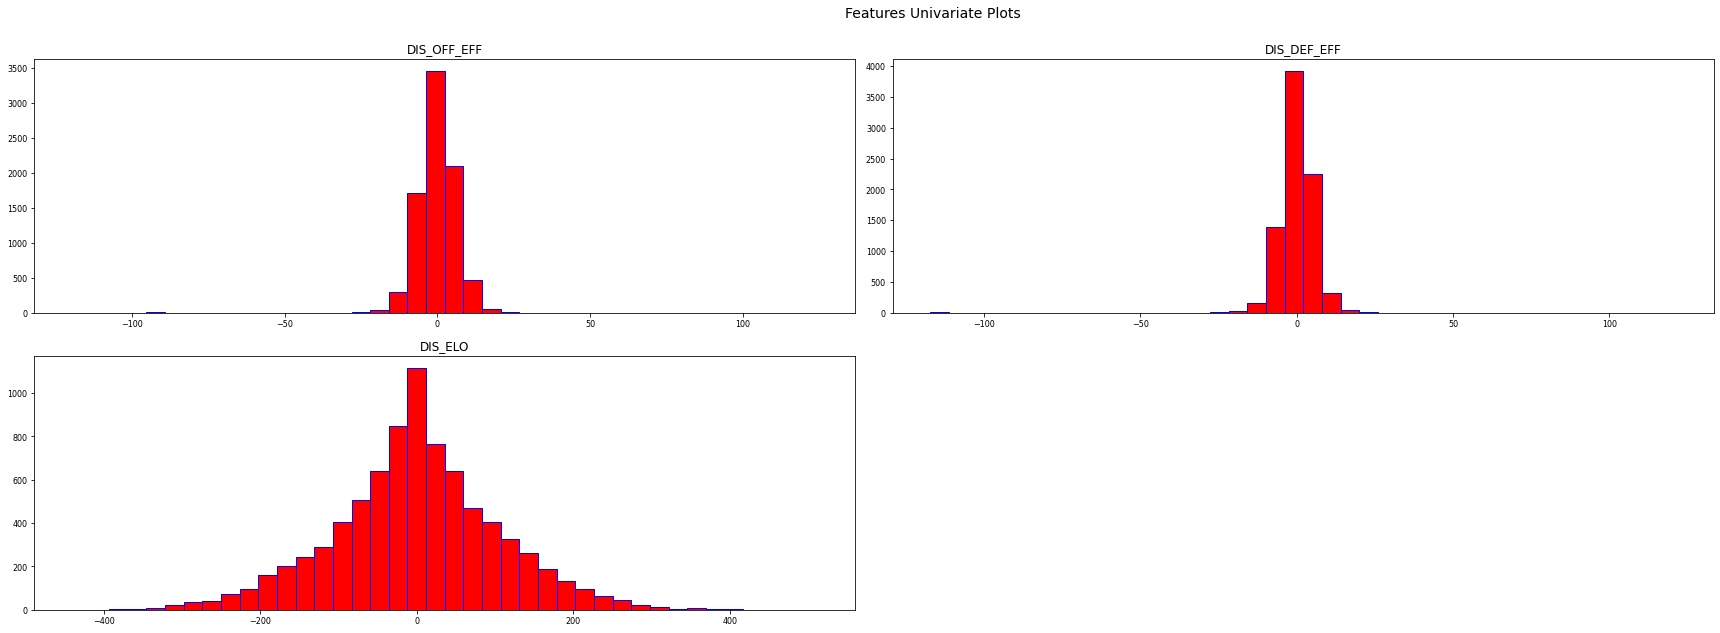

In [22]:
eda_plots(all_df, features_list,'Features Univariate Plots',(20,7))

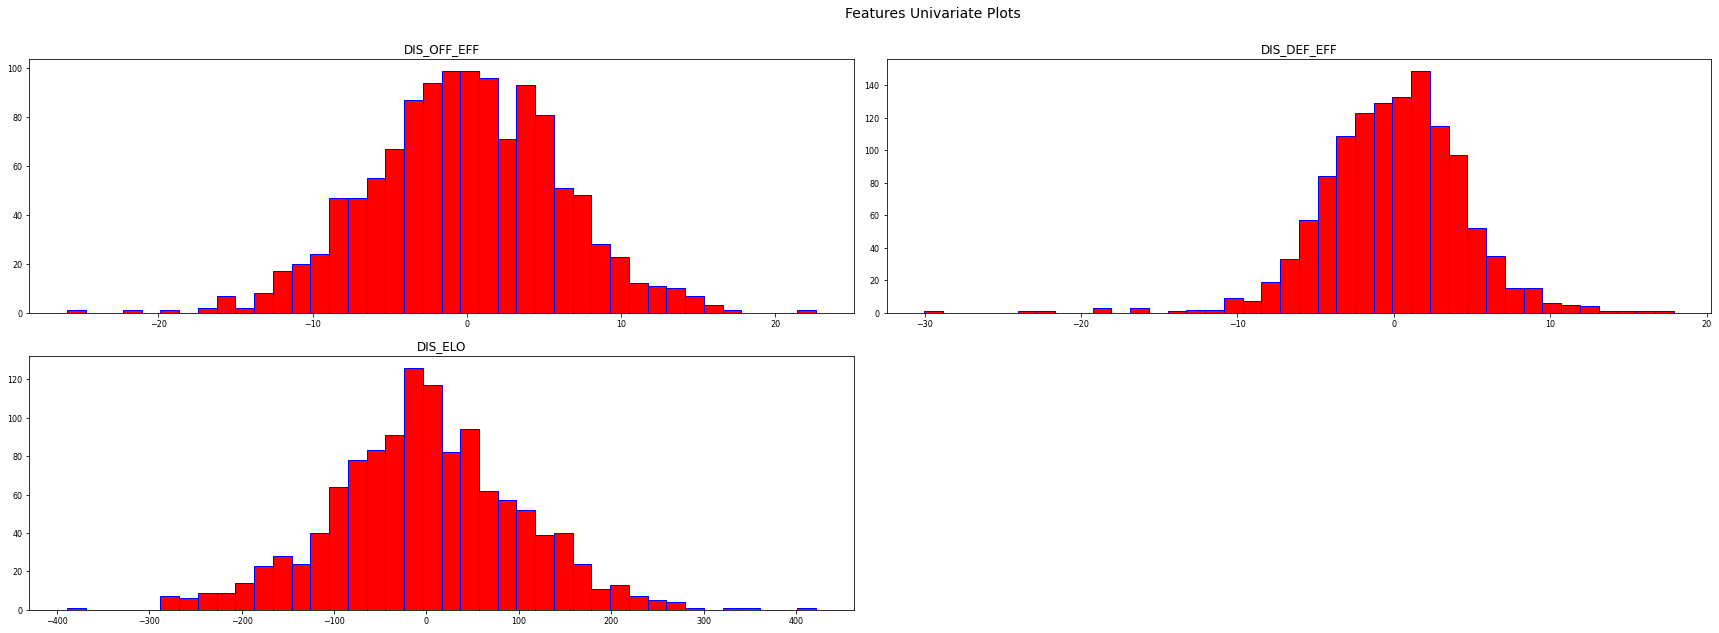

In [23]:
eda_plots(s2016, features_list,'Features Univariate Plots',(20,7))

#### Training model for each season
- training_df will be first half of each season
- test_df will be second half of each season

In [24]:
models_dict = {
    'Logistic Regression':LogisticRegression(),
    'Naive Bayes':GaussianNB(),
    'Decision Trees':DecisionTreeClassifier(),
    'SVM linear': svm.SVC(kernel='linear'),
    'SVM rbf': svm.SVC(kernel='rbf'),
    'Random Forest': RandomForestClassifier(n_estimators = 100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, objective='reg:logistic')
}

In [25]:
performance_data = {}

season = 2014
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    # splitting data into training and testing set
    train_df = df[(df['GAME_NO_x'] <= 41) | (df['GAME_NO_y'] <= 41 )]
    test_df = df[(df['GAME_NO_x'] > 41) | (df['GAME_NO_y'] > 41 )]

    # Creating independent and dependent variables df
    features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']
    # features = ['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    X_train = train_df[features]
    y_train = train_df['WL_x']
    X_test = test_df[features]
    y_test = test_df['WL_x']

    performance_data[season] = {} # store acc, precision, recall, f1 score for each season 

    # Training with differnent models
    for model_name in models_dict:
        m = models_dict[model_name]
        
        m.fit(X_train, y_train)
        predictions = m.predict(X_test)

        acc = accuracy_score(y_test,predictions)  # always true label first, then your predicted labels!
        precision = precision_score(y_test,predictions) 
        recall = recall_score(y_test,predictions) 
        f1 = f1_score(y_test,predictions)

        # adding into the performance data dict
        performance_data[season][model_name] = {}
        performance_data[season][model_name]['accuracy'] = acc
        performance_data[season][model_name]['precision'] = precision
        performance_data[season][model_name]['recall'] =recall
        performance_data[season][model_name]['f1'] = f1

    season += 1

In [26]:
perfromance_df = pd.DataFrame.from_dict({(i,j): performance_data[i][j] 
                           for i in performance_data.keys() 
                           for j in performance_data[i].keys()},
                       orient='index')
perfromance_df

accuracy  precision    recall        f1
2014 Logistic Regression  0.693910   0.783237  0.700258  0.739427
     Naive Bayes          0.687500   0.801887  0.658915  0.723404
     Decision Trees       0.573718   0.700997  0.545220  0.613372
     SVM linear           0.692308   0.782609  0.697674  0.737705
     SVM rbf              0.679487   0.771014  0.687339  0.726776
     Random Forest        0.602564   0.722045  0.583979  0.645714
     XGBoost              0.605769   0.728155  0.581395  0.646552
2015 Logistic Regression  0.719551   0.747449  0.794038  0.770039
     Naive Bayes          0.721154   0.754569  0.783198  0.768617
     Decision Trees       0.580128   0.644205  0.647696  0.645946
     SVM linear           0.709936   0.722749  0.826558  0.771176
     SVM rbf              0.705128   0.716628  0.829268  0.768844
     Random Forest        0.674679   0.703431  0.777778  0.738739
     XGBoost              0.658654   0.707447  0.720867  0.714094
2016 Logistic Regression  0.611200   0.654229  0.716621  0.684005
     Naive Bayes          0.622400   0.679452  0.675749  0.677596
     Decision Trees       0.547200   0.620690  0.588556  0.604196
     SVM linear           0.625600   0.648770  0.790191  0.712531
     SVM rbf              0.614400   0.665789  0.689373  0.677376
     Random Forest        0.608000   0.661376  0.681199  0.671141
     XGBoost              0.566400   0.628342  0.640327  0.634278
2017 Logistic Regression  0.674121   0.690647  0.793388  0.738462
     Naive Bayes          0.669329   0.707447  0.732782  0.719892
     Decision Trees       0.570288   0.635057  0.608815  0.621660
     SVM linear           0.672524   0.690821  0.787879  0.736165
     SVM rbf              0.672524   0.684579  0.807163  0.740834
     Random Forest        0.611821   0.651515  0.710744  0.679842
     XGBoost              0.599042   0.658192  0.641873  0.649930
2018 Logistic Regression  0.663462   0.668113  0.843836  0.745763
     Naive Bayes          0.669872   0.704370  0.750685  0.726790
     Decision Trees       0.592949   0.635697  0.712329  0.671835
     SVM linear           0.649038   0.647177  0.879452  0.745645
     SVM rbf              0.647436   0.663657  0.805479  0.727723
     Random Forest        0.613782   0.636564  0.791781  0.705739
     XGBoost              0.633013   0.661137  0.764384  0.709022
2019 Logistic Regression  0.647541   0.649770  0.726804  0.686131
     Naive Bayes          0.655738   0.684783  0.649485  0.666667
     Decision Trees       0.601093   0.629032  0.603093  0.615789
     SVM linear           0.655738   0.655963  0.737113  0.694175
     SVM rbf              0.647541   0.655502  0.706186  0.679901
     Random Forest        0.576503   0.604278  0.582474  0.593176
     XGBoost              0.571038   0.590244  0.623711  0.606516

#### MultiIndex df indexing and slicing

In [27]:
# perfromance_df.loc[2014, 'accuracy']

idx = pd.IndexSlice
perfromance_df.loc[idx[2014, :], 'accuracy']

2014  Logistic Regression    0.693910
      Naive Bayes            0.687500
      Decision Trees         0.573718
      SVM linear             0.692308
      SVM rbf                0.679487
      Random Forest          0.602564
      XGBoost                0.605769
Name: accuracy, dtype: float64

In [28]:
# new
for yr in range(2014, 2020):
    model_acc = perfromance_df.loc[idx[yr, :], 'accuracy'].idxmax()[1]
    model_f1 = perfromance_df.loc[idx[yr, :], 'f1'].idxmax()[1]
    acc = perfromance_df.loc[idx[yr, :], 'accuracy'].max()
    f1 = perfromance_df.loc[idx[yr, :], 'f1'].max()
    print(f'Model is with highest accuracy of {acc} in season {yr} is {model_acc}')
    print(f'Model is with highest f1 of {f1} in season {yr} is {model_f1}')
    print()

Model is with highest accuracy of 0.6939102564102564 in season 2014 is Logistic Regression
Model is with highest f1 of 0.7394270122783083 in season 2014 is Logistic Regression

Model is with highest accuracy of 0.7211538461538461 in season 2015 is Naive Bayes
Model is with highest f1 of 0.7711757269279393 in season 2015 is SVM linear

Model is with highest accuracy of 0.6256 in season 2016 is SVM linear
Model is with highest f1 of 0.7125307125307127 in season 2016 is SVM linear

Model is with highest accuracy of 0.6741214057507987 in season 2017 is Logistic Regression
Model is with highest f1 of 0.740834386852086 in season 2017 is SVM rbf

Model is with highest accuracy of 0.6698717948717948 in season 2018 is Naive Bayes
Model is with highest f1 of 0.7457627118644068 in season 2018 is Logistic Regression

Model is with highest accuracy of 0.6557377049180327 in season 2019 is Naive Bayes
Model is with highest f1 of 0.6941747572815534 in season 2019 is SVM linear



In [29]:
season_df = s2014 # change this to the season df you want to print out the confusion matrix for that season

for model_name in models_dict:
    # splitting data into training and testing set
    train_df = season_df[(season_df['GAME_NO_x'] <= 41) | (season_df['GAME_NO_y'] <= 41 )]
    test_df = season_df[(season_df['GAME_NO_x'] > 41) | (season_df['GAME_NO_y'] > 41 )]

    # Creating independent and dependent variables df
    features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']
    # features = ['DIS_AST', 'DIS_OREB', 'DIS_DREB', 'DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    X_train = train_df[features]
    y_train = train_df['WL_x']
    X_test = test_df[features]
    y_test = test_df['WL_x'] 

    m = models_dict[model_name]
    prediction = m.predict(X_test)

    print('*'*60)
    print(f'Classification Report ({model_name}): \n')
    print(classification_report(y_test,prediction)) 

    print('-'*60)
    print('Confusion Matrix: \n')

    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm,columns=[0,1],index=[0,1]) 
    # should it be columns=[1,0] instead? win = 1, lose = 0. 

    print('Predicted')
    print(cm_df,'Acutal')
    print('*'*60)
    print()
    print()

************************************************************
Classification Report (Logistic Regression): 

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       237
           1       0.74      0.74      0.74       387

    accuracy                           0.68       624
   macro avg       0.66      0.66      0.66       624
weighted avg       0.68      0.68      0.68       624

------------------------------------------------------------
Confusion Matrix: 

Predicted
     0    1
0  138   99
1  100  287 Acutal
************************************************************


************************************************************
Classification Report (Naive Bayes): 

              precision    recall  f1-score   support

           0       0.57      0.69      0.62       237
           1       0.78      0.68      0.73       387

    accuracy                           0.69       624
   macro avg       0.68      0.69      0.68       

### Multi Regression

In [30]:
multi_reg_performance = {}

season = 2014
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    train_df = df[(df['GAME_NO_x'] <= 41) | (df['GAME_NO_y'] <= 41 )]
    test_df = df[(df['GAME_NO_x'] > 41) | (df['GAME_NO_y'] > 41 )]

    features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']
    # features = ['DIS_OFF_EFF', 'DIS_ELO']
    X_train = train_df[features]
    y_train = train_df['PLUS_MINUS_x']
    X_test = test_df[features]
    y_test = test_df['WL_x']

    m = LinearRegression()
    m.fit(X_train, y_train)
    predictions = m.predict(X_test)

    for i, v in enumerate(predictions):
        if v > 0:
            predictions[i] = 1
        else:
            predictions[i] = 0

    acc = accuracy_score(y_test,predictions)
    precision = precision_score(y_test,predictions) 
    recall = recall_score(y_test,predictions) 
    f1 = f1_score(y_test,predictions)

    multi_reg_performance[season] = {}
    multi_reg_performance[season]['acc'] = acc
    multi_reg_performance[season]['prec'] = precision
    multi_reg_performance[season]['rec'] = recall
    multi_reg_performance[season]['f1'] = f1

    season += 1

In [31]:
multi_reg_df = pd.DataFrame.from_dict({(i): multi_reg_performance[i] 
                           for i in multi_reg_performance.keys()},
                       orient='index')
multi_reg_df

,acc,prec,rec,f1
2014,0.676282,0.741514,0.733850,0.737662
2015,0.722756,0.757895,0.780488,0.769025
2016,0.624000,0.657895,0.749319,0.700637
2017,0.682109,0.683036,0.842975,0.754624
2018,0.663462,0.682353,0.794521,0.734177
2019,0.644809,0.641593,0.747423,0.690476


## Ensemble Method

In [32]:
ensemble_performance = {}

season = 2014
for df in (s2014, s2015, s2016, s2017, s2018, s2019):

    train_df = df[(df['GAME_NO_x'] <= 41) | (df['GAME_NO_y'] <= 41 )]
    test_df = df[(df['GAME_NO_x'] > 41) | (df['GAME_NO_y'] > 41 )]

    features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']
    # features = ['DIS_OFF_EFF', 'DIS_ELO', 'HOME_COURT_x']
    X_train = train_df[features]
    y_train = train_df['WL_x']
    y_train_reg = train_df['PLUS_MINUS_x']
    X_test = test_df[features]
    y_test = test_df['WL_x']

    # fitting different models
    model1 = LogisticRegression()
    model2 = GaussianNB()
    model3 = svm.SVC(kernel='linear')
    model4 = svm.SVC(kernel='rbf')
    model5 = DecisionTreeClassifier()
    model6 = RandomForestClassifier(n_estimators = 100)
    model7 =LinearRegression()

    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    model3.fit(X_train, y_train)
    model4.fit(X_train, y_train)
    # model5.fit(X_train, y_train)
    # model6.fit(X_train, y_train)
    model7.fit(X_train, y_train_reg)

    pred1 = model1.predict(X_test)
    pred2 = model2.predict(X_test)
    pred3 = model3.predict(X_test)
    pred4 = model4.predict(X_test)
    # pred5 = model5.predict(X_test)
    # pred6 = model6.predict(X_test)
    pred7 = model7.predict(X_test)

    final_pred = []
    for i in range(len(y_test)):
        if pred7[i] > 0:
            pred7[i] = 1
        else:
            pred7[i] = 0
        final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred3[i], pred4[i], pred7[i]]))
        # final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred7[i]]))

    acc = accuracy_score(y_test,final_pred)  # always true label first, then your predicted labels!
    precision = precision_score(y_test,final_pred) 
    recall = recall_score(y_test,final_pred) 
    f1 = f1_score(y_test,final_pred)

    ensemble_performance[season] = {}
    ensemble_performance[season]['acc'] = acc
    ensemble_performance[season]['prec'] = precision
    ensemble_performance[season]['rec'] = recall
    ensemble_performance[season]['f1'] = f1

    season += 1

In [33]:
ensemble_df = pd.DataFrame.from_dict({(i): ensemble_performance[i] 
                           for i in ensemble_performance.keys()},
                       orient='index')
ensemble_df

,acc,prec,rec,f1
2014,0.693910,0.783237,0.700258,0.739427
2015,0.719551,0.747449,0.794038,0.770039
2016,0.616000,0.656790,0.724796,0.689119
2017,0.672524,0.689904,0.790634,0.736842
2018,0.660256,0.675057,0.808219,0.735661
2019,0.650273,0.651376,0.731959,0.689320


## Calculate the actual winning percentage of the team with a higher WL record
- games when either teams are playing their first games are omitted

In [34]:
season = 2014
for df in (s2014, s2015, s2016, s2017, s2018, s2019):
    winlose_record = {
    'ATL': {'W': 0, 'L': 0, 'WL%': 0},
    'BKN': {'W': 0, 'L': 0, 'WL%': 0},
    'BOS': {'W': 0, 'L': 0, 'WL%': 0},
    'CHA': {'W': 0, 'L': 0, 'WL%': 0},
    'CHI': {'W': 0, 'L': 0, 'WL%': 0},
    'CLE': {'W': 0, 'L': 0, 'WL%': 0},
    'DAL': {'W': 0, 'L': 0, 'WL%': 0},
    'DEN': {'W': 0, 'L': 0, 'WL%': 0},
    'DET': {'W': 0, 'L': 0, 'WL%': 0},
    'GSW': {'W': 0, 'L': 0, 'WL%': 0},
    'HOU': {'W': 0, 'L': 0, 'WL%': 0},
    'IND': {'W': 0, 'L': 0, 'WL%': 0},
    'LAC': {'W': 0, 'L': 0, 'WL%': 0},
    'LAL': {'W': 0, 'L': 0, 'WL%': 0},
    'MEM': {'W': 0, 'L': 0, 'WL%': 0},
    'MIA': {'W': 0, 'L': 0, 'WL%': 0},
    'MIL': {'W': 0, 'L': 0, 'WL%': 0},
    'MIN': {'W': 0, 'L': 0, 'WL%': 0},
    'NOP': {'W': 0, 'L': 0, 'WL%': 0},
    'NYK': {'W': 0, 'L': 0, 'WL%': 0},
    'OKC': {'W': 0, 'L': 0, 'WL%': 0},
    'ORL': {'W': 0, 'L': 0, 'WL%': 0},
    'PHI': {'W': 0, 'L': 0, 'WL%': 0},
    'PHX': {'W': 0, 'L': 0, 'WL%': 0},
    'POR': {'W': 0, 'L': 0, 'WL%': 0},
    'SAC': {'W': 0, 'L': 0, 'WL%': 0},
    'SAS': {'W': 0, 'L': 0, 'WL%': 0},
    'TOR': {'W': 0, 'L': 0, 'WL%': 0},
    'UTA': {'W': 0, 'L': 0, 'WL%': 0},
    'WAS': {'W': 0, 'L': 0, 'WL%': 0}    
    }
    win_counts = 0
    total_games = 0

    for i, row in df.iterrows():
        team_x = row['TEAM_ABBREVIATION_x']
        team_y = row['TEAM_ABBREVIATION_y']

        x_record = winlose_record[team_x]['WL%']
        y_record = winlose_record[team_y]['WL%']

        # higher record team winning counts +1 if they actually wins
        if ((x_record > y_record) and (row['WL_x'] == 1)) or ((y_record > x_record) and (row['WL_y'] == 1)):
            win_counts += 1
        total_games += 1

        # updating the WL dict after every game
        if row['WL_x'] == 1:
            winlose_record[team_x]['W'] += 1
            winlose_record[team_y]['L'] += 1
        else:
            winlose_record[team_y]['W'] += 1
            winlose_record[team_x]['L'] += 1
        winlose_record[team_x]['WL%'] = winlose_record[team_x]['W'] / (winlose_record[team_x]['W'] + winlose_record[team_x]['L'])
        winlose_record[team_y]['WL%'] = winlose_record[team_y]['W'] / (winlose_record[team_y]['W'] + winlose_record[team_y]['L'])
    
    higher_record_winning_percentage = round(win_counts / total_games, 4)

    print(f'Actual winning % of higher record team in season {season} is {higher_record_winning_percentage}')
    season +=1

Actual winning % of higher record team in season 2014 is 0.648
Actual winning % of higher record team in season 2015 is 0.6348
Actual winning % of higher record team in season 2016 is 0.5898
Actual winning % of higher record team in season 2017 is 0.6129
Actual winning % of higher record team in season 2018 is 0.6145
Actual winning % of higher record team in season 2019 is 0.6241


- Ensemble model performed better than the actual higher WL record teams' winning percentage

## Using ensemble model against current season (Season 2020-2021)
- Only 72 games will be played in season 2020-2021, thus the training set will using the first 36 games
- After model is trained using the first 36 games, then we will predict the remaining games
- We then compare the model accuracy against the actual higher WL record teams's winning percentage in season 2020

In [47]:
s2020 = pd.read_csv('../data/season_history.csv') # data colleted up till 12 May 2021
s2020_df = s2020.drop(s2020[(s2020["GAME_NO_x"] == 1) | (s2020["GAME_NO_y"] == 1)].index)

In [48]:
s2020_performance = {}

train_df = s2020_df[(s2020_df['GAME_NO_x'] <= 36) | (s2020_df['GAME_NO_y'] <= 36 )]
test_df = s2020_df[(s2020_df['GAME_NO_x'] > 36) | (s2020_df['GAME_NO_y'] > 36 )]

features = ['DIS_OFF_EFF', 'DIS_DEF_EFF', 'DIS_ELO']
# features = ['DIS_OFF_EFF', 'DIS_ELO', 'HOME_COURT_x']
X_train = train_df[features]
y_train = train_df['WL_x']
y_train_reg = train_df['PLUS_MINUS_x']
X_test = test_df[features]
y_test = test_df['WL_x']

# fitting different models
model1 = LogisticRegression()
model2 = GaussianNB()
model3 = svm.SVC(kernel='linear')
model4 = svm.SVC(kernel='rbf')
model5 = DecisionTreeClassifier()
model6 = RandomForestClassifier(n_estimators = 100)
model7 =LinearRegression()

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)
# model5.fit(X_train, y_train)
# model6.fit(X_train, y_train)
model7.fit(X_train, y_train_reg)

pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)
pred4 = model4.predict(X_test)
# pred5 = model5.predict(X_test)
# pred6 = model6.predict(X_test)
pred7 = model7.predict(X_test)

final_pred = []
for i in range(len(y_test)):
    if pred7[i] > 0:
        pred7[i] = 1
    else:
        pred7[i] = 0
    final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred3[i], pred4[i], pred7[i]]))
    # final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred7[i]]))

acc = accuracy_score(y_test,final_pred)  # always true label first, then your predicted labels!
precision = precision_score(y_test,final_pred) 
recall = recall_score(y_test,final_pred) 
f1 = f1_score(y_test,final_pred)

s2020_performance['acc'] = acc
s2020_performance['prec'] = precision
s2020_performance['rec'] = recall
s2020_performance['f1'] = f1

In [49]:
s2020_performance

{'acc': 0.658203125,
 'prec': 0.6804123711340206,
 'rec': 0.7071428571428572,
 'f1': 0.6935201401050789}

In [45]:
winlose_record = {
'ATL': {'W': 0, 'L': 0, 'WL%': 0},
'BKN': {'W': 0, 'L': 0, 'WL%': 0},
'BOS': {'W': 0, 'L': 0, 'WL%': 0},
'CHA': {'W': 0, 'L': 0, 'WL%': 0},
'CHI': {'W': 0, 'L': 0, 'WL%': 0},
'CLE': {'W': 0, 'L': 0, 'WL%': 0},
'DAL': {'W': 0, 'L': 0, 'WL%': 0},
'DEN': {'W': 0, 'L': 0, 'WL%': 0},
'DET': {'W': 0, 'L': 0, 'WL%': 0},
'GSW': {'W': 0, 'L': 0, 'WL%': 0},
'HOU': {'W': 0, 'L': 0, 'WL%': 0},
'IND': {'W': 0, 'L': 0, 'WL%': 0},
'LAC': {'W': 0, 'L': 0, 'WL%': 0},
'LAL': {'W': 0, 'L': 0, 'WL%': 0},
'MEM': {'W': 0, 'L': 0, 'WL%': 0},
'MIA': {'W': 0, 'L': 0, 'WL%': 0},
'MIL': {'W': 0, 'L': 0, 'WL%': 0},
'MIN': {'W': 0, 'L': 0, 'WL%': 0},
'NOP': {'W': 0, 'L': 0, 'WL%': 0},
'NYK': {'W': 0, 'L': 0, 'WL%': 0},
'OKC': {'W': 0, 'L': 0, 'WL%': 0},
'ORL': {'W': 0, 'L': 0, 'WL%': 0},
'PHI': {'W': 0, 'L': 0, 'WL%': 0},
'PHX': {'W': 0, 'L': 0, 'WL%': 0},
'POR': {'W': 0, 'L': 0, 'WL%': 0},
'SAC': {'W': 0, 'L': 0, 'WL%': 0},
'SAS': {'W': 0, 'L': 0, 'WL%': 0},
'TOR': {'W': 0, 'L': 0, 'WL%': 0},
'UTA': {'W': 0, 'L': 0, 'WL%': 0},
'WAS': {'W': 0, 'L': 0, 'WL%': 0}    
}
win_counts = 0
total_games = 0

for i, row in s2020_df.iterrows():
    team_x = row['TEAM_ABBREVIATION_x']
    team_y = row['TEAM_ABBREVIATION_y']

    x_record = winlose_record[team_x]['WL%']
    y_record = winlose_record[team_y]['WL%']

    # higher record team winning counts +1 if they actually wins
    if ((x_record > y_record) and (row['WL_x'] == 1)) or ((y_record > x_record) and (row['WL_y'] == 1)):
        win_counts += 1
    total_games += 1

    # updating the WL dict after every game
    if row['WL_x'] == 1:
        winlose_record[team_x]['W'] += 1
        winlose_record[team_y]['L'] += 1
    else:
        winlose_record[team_y]['W'] += 1
        winlose_record[team_x]['L'] += 1
    winlose_record[team_x]['WL%'] = winlose_record[team_x]['W'] / (winlose_record[team_x]['W'] + winlose_record[team_x]['L'])
    winlose_record[team_y]['WL%'] = winlose_record[team_y]['W'] / (winlose_record[team_y]['W'] + winlose_record[team_y]['L'])

higher_record_winning_percentage = round(win_counts / total_games, 4)

print(f'Actual winning % of higher record team in season 2020 is {higher_record_winning_percentage}')

Actual winning % of higher record team in season 2020 is 0.5974


## Test against Season 2021
- When modelling, we split the season into first and second half of a season, where first half is the train set and second half is the test set. 
- However, in actual deployment, we should be consistently updating our data for the season and using the updated data to re-train our model. Essentially, re train model after all the games everyday.
- This will be shown in our deployment app. 


### Test using season history - ensemble model for prediction based on:
- Linear Regression
- Logistic Regression
- SVM Linear
- SVM RBF
- NAive Bayes

<br>

- We predicted games from mid season onwards, model will be trained with ALL the games prior to that day's game

In [2]:
df = pd.read_csv("../data/season_history.csv")
df = df[df["Prediction"].isnull() == False]
df

,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,WL_x,MIN_x,PTS_x,FGM_x,FGA_x,FG_PCT_x,...,AVG_OREB_y,AVG_DREB_x,AVG_DREB_y,OFF_EFF_x,OFF_EFF_y,DEF_EFF_x,DEF_EFF_y,ELO_x,ELO_y,Prediction
611,LAL,Los Angeles Lakers,22000640,2021-03-20,0,242,94,34,81,0.420,...,11.170732,35.585366,34.707317,111.70,113.76,105.63,111.69,1580.717596,1512.673195,1.0
612,PHI,Philadelphia 76ers,22000641,2021-03-20,1,238,129,48,86,0.558,...,10.439024,36.048780,32.341463,112.33,113.24,107.38,117.83,1595.135299,1454.733411,1.0
617,BOS,Boston Celtics,22000167,2021-03-21,1,241,112,40,88,0.455,...,10.512195,32.707317,36.097561,112.39,105.05,111.87,111.65,1479.156852,1409.975748,1.0
619,DEN,Denver Nuggets,22000646,2021-03-21,0,241,108,44,88,0.500,...,11.780488,33.878049,34.707317,116.41,115.21,110.96,115.21,1573.513467,1455.273077,1.0
621,CLE,Cleveland Cavaliers,22000648,2021-03-21,1,241,116,39,77,0.506,...,9.243902,31.902439,31.780488,104.79,111.93,113.05,111.69,1423.588971,1440.672008,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,IND,Indiana Pacers,22001061,2021-05-15,0,241,115,46,89,0.517,...,9.657143,33.685714,34.600000,111.26,108.92,111.37,106.33,1475.997079,1520.796498,1.0
1061,MIL,Milwaukee Bucks,22001062,2021-05-15,1,242,122,46,86,0.535,...,8.057143,37.857143,33.528571,116.18,110.80,110.43,110.76,1600.029788,1569.508053,1.0
1062,MIN,Minnesota Timberwolves,22001063,2021-05-15,0,242,108,39,95,0.411,...,10.671429,33.114286,33.557143,108.16,112.82,113.67,111.49,1419.925771,1481.197519,0.0
1063,NYK,New York Knicks,22001064,2021-05-15,1,263,118,45,88,0.511,...,10.528571,35.342857,33.157143,109.87,109.84,107.63,111.63,1566.757948,1463.509891,1.0


In [3]:
acc = accuracy_score(df["WL_x"], df["Prediction"])
f1 = f1_score(df["WL_x"], df["Prediction"])

print("Accuracy:",round(acc,4))
print("F1:",round(f1,4))

Accuracy: 0.6689
F1: 0.7008
